In [1]:
%load_ext autoreload
%autoreload 3 --print

In [273]:
import torch as th
import numpy as np
from torch import optim
from torch import nn
from dynrn.rnntasks import SimpleTasks
from dynrn.viz import util as vu
import matplotlib.pyplot as plt
from pathlib import Path
import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from dynrn.viz import styles
colors, plotter = styles.init_plt(
    '../plots/notebook/rnn-run',
    fmt = 'pdf')
plot_root = Path(plotter.plot_dir)

In [1]:
x, y = SimpleTasks.fixed_interval(
    interval = 4, iti_halflife = 3, iti_min = 3, session_length = 180, n_sessions = 100, n_dim = 1
)
x = th.tensor(x, dtype=th.float32)
y = th.tensor(y, dtype=th.float32)

NameError: name 'SimpleTasks' is not defined

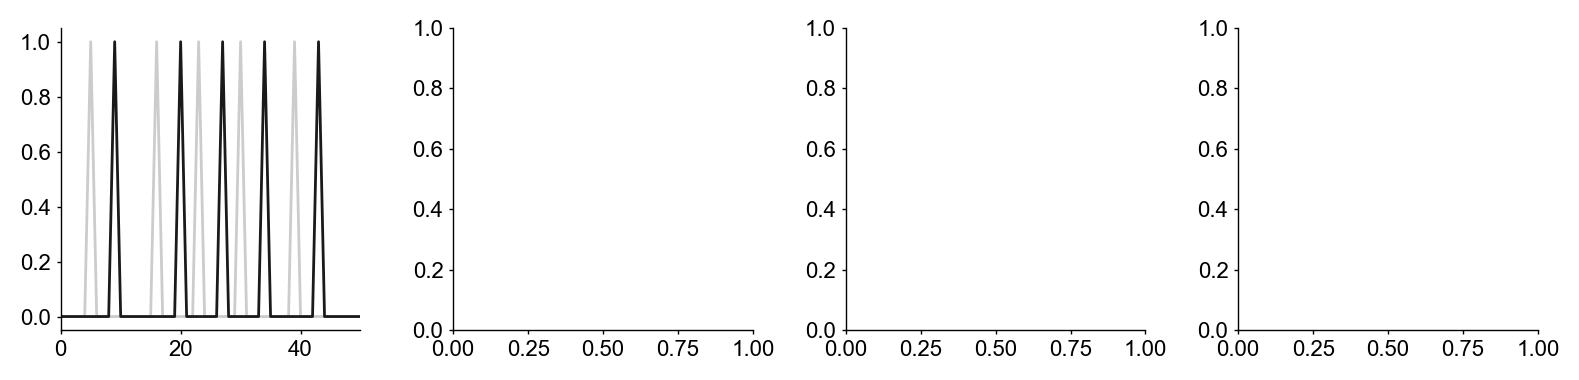

In [245]:
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
for i in range(x.shape[-1]):
    ax[i].plot(x.numpy()[0, :, i], color = colors.subtle)
    ax[i].plot(y.numpy()[0, :, i], color = colors.neutral)
ax[0].set_xlim(0, 50)
plotter.finalize(fig, None)

In [11]:
class RNN(nn.Module):
    def __init__(self, nx = 4, nh = 10, ny=None):
        super().__init__()
        
        if ny is None:
            ny = nx
        self.rnn = nn.RNN(nx, nh, 1, 'relu', bias = False, batch_first=True)
        self.h2y = nn.Linear(nh, ny)

    def forward(self, x):
        h, _ = self.rnn(x)
        x = self.h2y(h)
        return x
    
class RNNd(nn.Module):
    def __init__(self, nx = 4, nh = 10, ny=None):
        super().__init__()
        if ny is None:
            ny = nx

        self.nx = nx
        self.nh = nh
        self.ny = ny
        
        self.i2h = nn.Linear(nx, nh, bias = False)
        self.h2h = nn.Linear(nh, nh, bias = False)
        self.h2y = nn.Linear(nh, ny, bias = False)
        self.act = nn.Tanh()

    def forward(self, x, h):
        h = self.act(self.i2h(x) + self.h2h(h))
        y = self.h2y(h)
        return y, h
    
    def seq_forward(self, x, h):
        y = []
        hs = []
        for i in range(x.shape[1]):
            y_, h = self.forward(x[:, i], h)
            y.append(y_)
            hs.append(h)
        return th.stack(y, dim=1), th.stack(hs, dim=1)
    
    def init_hidden(self, batch_size):
        return th.zeros(batch_size, self.nh)
    
    def init_weights(self):
        pass

In [9]:
def fit_rnn(rnn, x, y, opt, loss_fn = nn.MSELoss(), n_steps = 2000):
    """
    Fit an RNN to batched sequences.

    Parameters
    ----------
    rnn : nn.Module
        The RNN model. Should have a function `seq_forward` that takes an input
        tensor and an initial hidden state tensor. And a function `init_hidden`
        that returns an initial hidden state tensor given a batch size.
    x : th.Tensor
        The input tensor. Should have shape (n_batch, n_step, n_inputs).
    y : th.Tensor
        The target tensor. Should have shape (n_batch, n_step, n_outputs).
    opt : optim.Optimizer
        The optimizer to use.
    loss_fn : nn.Module
        The loss function to use.
    n_steps : int
        The number of optimization steps to take.
    """

    losses = []
    yhats = []
    h_hist = []

    for i in tqdm.trange(n_steps):
        opt.zero_grad()
        h_init = rnn.init_hidden(x.shape[0])
        yhat, hs = rnn.seq_forward(x, h_init)
        loss = loss_fn(yhat, y)
        loss.backward()
        opt.step()
        losses.append(loss.detach().numpy())
        yhats.append(yhat.detach().numpy())
        h_hist.append(hs.detach().numpy())

    return np.stack(losses), np.stack(yhats), h_hist

In [13]:
rnn = RNNd(x.shape[-1], 80)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
losses, yhats, _ = fit_rnn(rnn, x, y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:21<00:00, 46.05it/s]


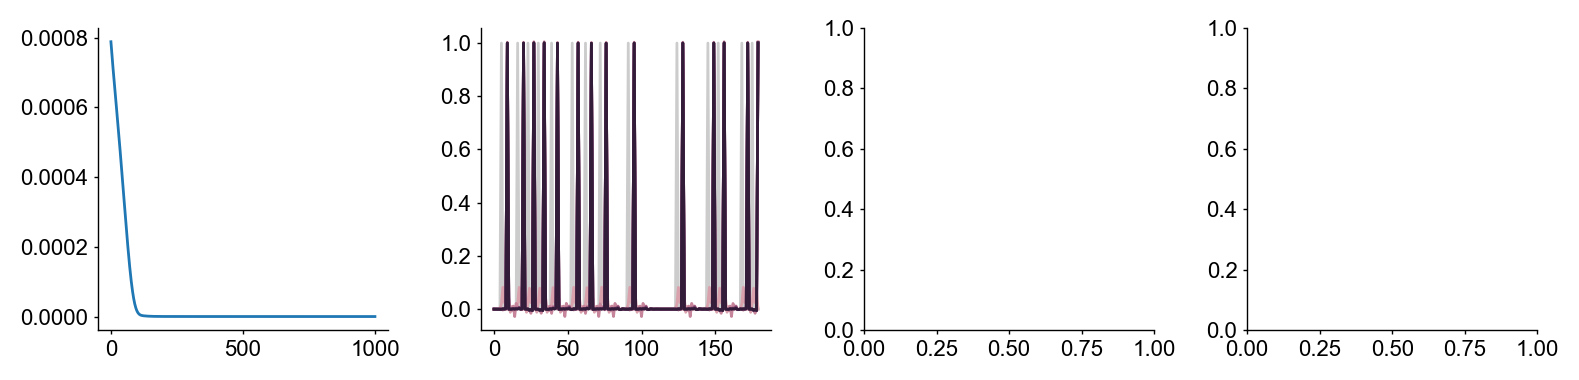

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(8, 2))
session = 0
skip = 150
ax[0].plot(losses)

pal = colors.ch0(np.arange(0, len(losses), skip))
for i in range(x.shape[-1]):
    ax[i+1].plot(x.numpy()[session, :, i], color=colors.subtle)
    for j in range(0, len(losses), skip):
        ax[i+1].plot(yhats[j, session, :, i], color=pal[j])
plotter.finalize(fig, None)

In [251]:
class SignedLinear(nn.Module):
    def __init__(self, n, n_out = None, sign = 1, scale = 1, allow_diag = True):
        super().__init__()
        self.n_in = n
        self.sign = sign
        self.scale = scale

        self.n_out = n if n_out is None else n_out
        if not allow_diag:
            self.mask = 1 - th.eye(n)
            self.n_out = n
        else:
            self.mask = 1
        
        self.weight = nn.Parameter(th.Tensor(self.n_out, self.n_in))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        with th.no_grad():
            self.weight.set_(th.sqrt(th.abs(self.weight)) / 2)

    def forward(self, input):
        # w = self.scale * (self.weight ** 2) * self.mask
        return input @ self._weight().T
    
    def _weight(self):
        return (self.sign * self.scale) * (self.weight ** 2) * self.mask

def init_dynamical_rnn(self, nx, nh, ny = None, alpha = 0.1, act = nn.Sigmoid(), h_bias = 0, w_scale = 1, act_ofs = 0):
    if ny is None:
        ny = nx

    self.nx = nx
    self.nh = nh
    self.ny = ny

    self.act = act
    self.alpha = alpha
    self.h_bias = h_bias
    self.w_scale = w_scale
    self.act_ofs = act_ofs


class NegRNN(RNNd):
    def __init__(self, nx = 4, nh = 10, ny=None, alpha = 0.1, act = nn.Sigmoid(), h_bias = 0, w_scale = 1, act_ofs = 0):
        """
        Approximate dynamical RNN with negative weights.

        Parameters
        ----------
        alpha : float
            Step size divided by time constant, or equivalently a coefficient
            for convex combination of (in [0, 1]) $h_{t-1}$ and $f(h_{t-1})$ in
            the hidden state update rule, with `alpha` equal to 1 corresponding
            to a no-memory update.
        """
        nn.Module.__init__(self)
        init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)
    
        self.i2h = nn.Linear(self.nx, self.nh, bias = False)
        self.h2h = SignedLinear(self.nh, sign = -1, allow_diag=False) #nn.Linear(nh, nh, bias = False)
        self.h2y = nn.Linear(self.nh, self.ny, bias = False)

    def forward(self, x, h):
        h_act = self.act(h + self.h_bias) + self.act_ofs
        fh = self.w_scale * self.h2h(h_act) + self.i2h(x)
        h_new = (1 - self.alpha) * h + self.alpha * fh
        y = self.h2y(h_new)
        return y, h_new

class BasicRNN(NegRNN):

    def __init__(self, nx, nh, ny = None, alpha = 0.1, act = nn.Sigmoid(), h_bias = 0, w_scale = 1, act_ofs = 0):
        nn.Module.__init__(self)
        init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)

        self.i2h = nn.Linear(self.nx, self.nh, bias = False)
        self.h2h = nn.Linear(self.nh, self.nh, bias = False)
        self.h2y = nn.Linear(self.nh, self.ny, bias = False)



In [242]:
def plot_rnn_training(losses, yhats, x, start = 0, pal = colors.ch0, n_iter = 5, session = 0, col_buffer = 3):
    skip = len(losses) // n_iter

    fig, ax = plt.subplots(1, x.shape[-1] + 1, figsize=(2 * (x.shape[-1] + 1), 2))
    ax[0].plot(losses, color = colors.subtle)

    buf = col_buffer * skip
    pal = colors.ch0(np.arange(start - buf, len(losses) + buf, skip))
    for i in range(x.shape[-1]):
        ax[i+1].plot(x.numpy()[session, :, i], color=colors.subtle)
        for j in range(start, len(losses), skip):
            ax[0].plot([j], [losses[j]], 'o', ms = 3, color = pal[j])
            ax[i+1].plot(yhats[j, session, :, i], color=pal[j])

    return fig, ax
    

#### failure in a bunch of networks

Failure with negative weights and sigmoid

In [83]:
th.manual_seed(0)
rnn = NegRNN(x.shape[-1], 80, alpha = 0.8, act = nn.Sigmoid())
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=3e-6)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 1000)

/var/folders/yl/fzvpkkfs7md45qk6gcq3q27r0000gn/T/ipykernel_41099/1553940090.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  w = th.abs(nn.init.xavier_uniform(self.weight))
100%|██████████| 1000/1000 [00:29<00:00, 34.02it/s]


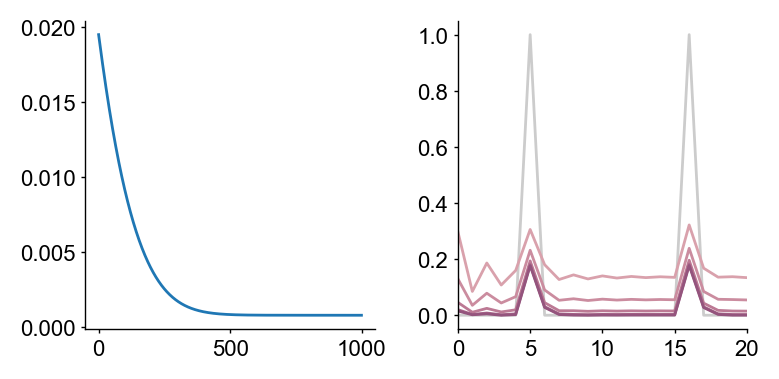

In [84]:
fig, ax = plt.subplots(1, x.shape[-1] + 1, figsize=(2 * (x.shape[-1] + 1), 2))
session = 0
skip = 200
start = 0
ax[0].plot(losses)

pal = colors.ch0(np.arange(start, len(losses) + 4 * skip, skip))
for i in range(x.shape[-1]):
    ax[i+1].plot(x.numpy()[session, :, i], color=colors.subtle)
    for j in range(start, len(losses), skip):
        ax[i+1].plot(yhats[j, session, :, i], color=pal[j])
ax[1].set_xlim(0, 20)
plotter.finalize(fig, None)

Failure with negative weights and Tanh

In [93]:
th.manual_seed(0)
rnn = NegRNN(x.shape[-1], 80, alpha = 0.8, act = nn.Tanh())
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=3e-6)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:34<00:00, 29.00it/s]


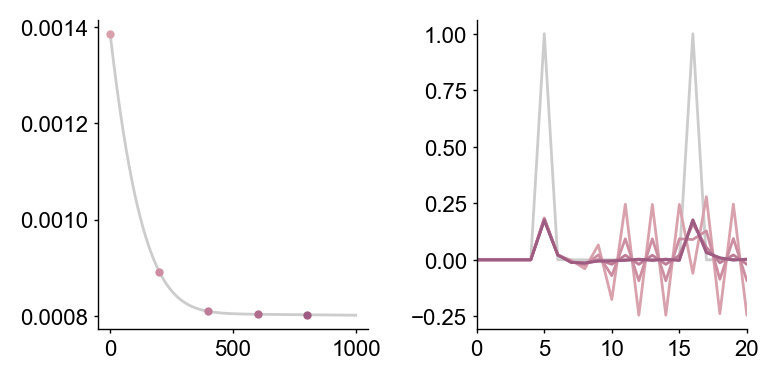

In [94]:
fig, ax = plt.subplots(1, x.shape[-1] + 1, figsize=(2 * (x.shape[-1] + 1), 2))
session = 0
skip = 200
start = 0
ax[0].plot(losses, color = colors.subtle)

pal = colors.ch0(np.arange(start, 2*len(losses), skip))
for i in range(x.shape[-1]):
    ax[i+1].plot(x.numpy()[session, :, i], color=colors.subtle)
    for j in range(start, len(losses), skip):
        ax[0].plot([j], [losses[j]], 'o', ms = 3, color = pal[j])
        ax[i+1].plot(yhats[j, session, :, i], color=pal[j])
ax[1].set_xlim(0, 20)
plotter.finalize(fig, None)

Success with freely signed weights, tanh activation

In [62]:
th.manual_seed(0)
rnn = BasicRNN(x.shape[-1], 80, alpha = 0.8, act = nn.Tanh(), w_scale=1)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:33<00:00, 30.13it/s]


In [49]:
# lst, yht, hst = losses, yhats, hs
# losses, yhats, hs = lst, yht, hst

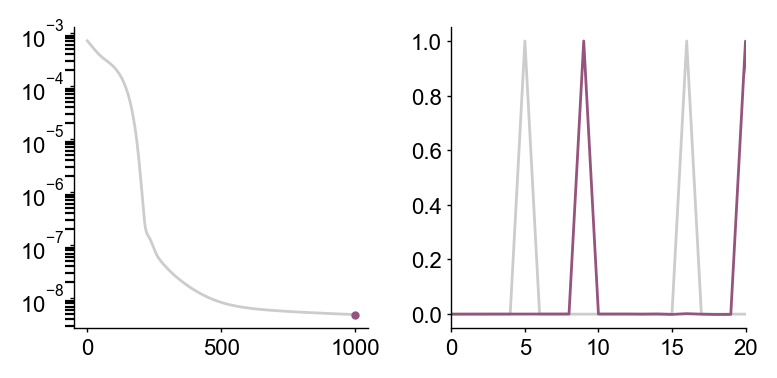

In [63]:
fig, ax = plt.subplots(1, x.shape[-1] + 1, figsize=(2 * (x.shape[-1] + 1), 2))
session = 0
skip = 200
start = 999
ax[0].plot(losses, color = colors.subtle)

pal = colors.ch0(np.arange(start-3*skip, len(losses) + 3 * skip, skip))
for i in range(x.shape[-1]):
    ax[i+1].plot(x.numpy()[session, :, i], color=colors.subtle)
    for j in range(start, len(losses), skip):
        ax[0].plot([j], [losses[j]], 'o', ms = 3, color = pal[j])
        ax[i+1].plot(yhats[j, session, :, i], color=pal[j])
ax[1].set_xlim(0, 20)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

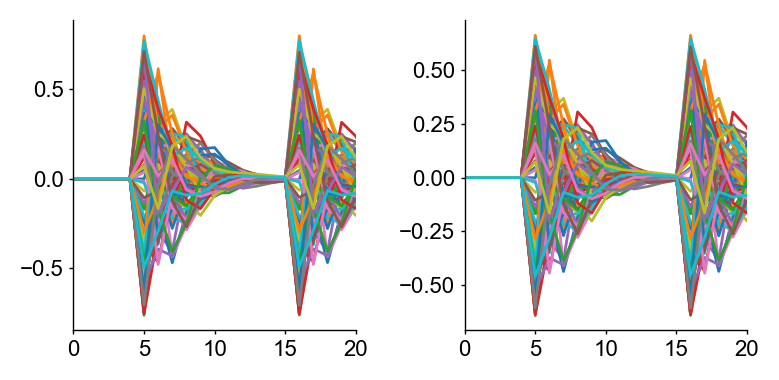

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharex = True)
ax[0].plot(hs[100][0, :, :])
ax[1].plot(rnn.act(th.tensor(hs[100][0, :, :])))
ax[0].set_xlim(0, 20)
plotter.finalize(fig, None)

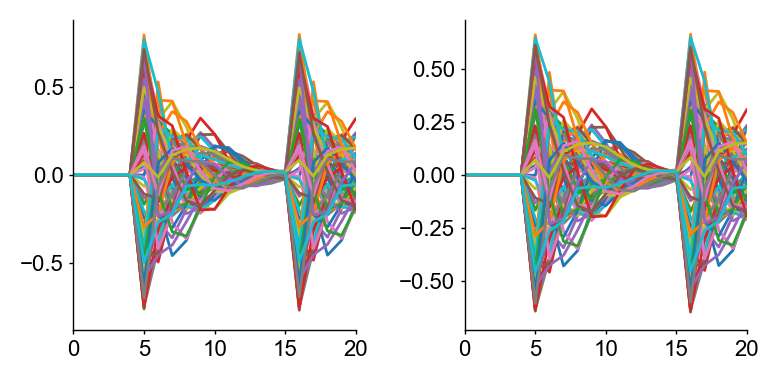

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharex = True)
ax[0].plot(hs[100][0, :, :])
ax[1].plot(rnn.act(th.tensor(hs[100][0, :, :])))
ax[0].set_xlim(0, 20)
plotter.finalize(fig, None)

Failure with freely signed weights, sigmoid activation

In [311]:
# th.manual_seed(0)
# rnn = BasicRNN(x.shape[-1], 80, alpha = 0.8, act = nn.Sigmoid(), w_scale = 1, h_bias = 0, act_ofs = 0)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 2000)

100%|██████████| 2000/2000 [01:06<00:00, 30.10it/s]


In [240]:
# lss, yhs, hss = losses, yhats, hs
# losses, yhats, hs = lss, yhs, hss

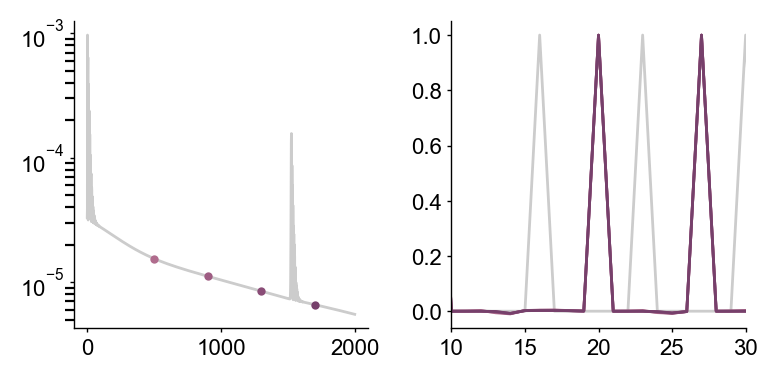

In [312]:
fig, ax = plot_rnn_training(losses, yhats, x, start = 500, col_buffer=3)
ax[1].set_xlim(10, 30)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

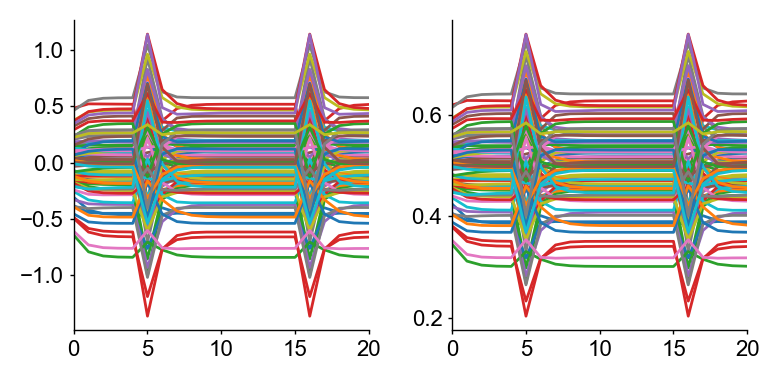

In [261]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharex = True)
ax[0].plot(hs[0][0, :, :])
ax[1].plot(rnn.act(th.tensor(hs[0][0, :, :]) + rnn.h_bias))
ax[0].set_xlim(0, 20)
plotter.finalize(fig, None)

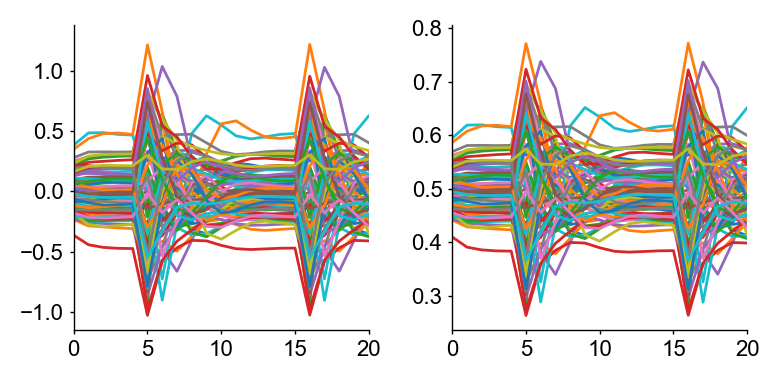

In [263]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharex = True)
ax[0].plot(hs[2000][0, :, :])
ax[1].plot(rnn.act(th.tensor(hs[2000][0, :, :]) + rnn.h_bias))
ax[0].set_xlim(0, 20)
plotter.finalize(fig, None)

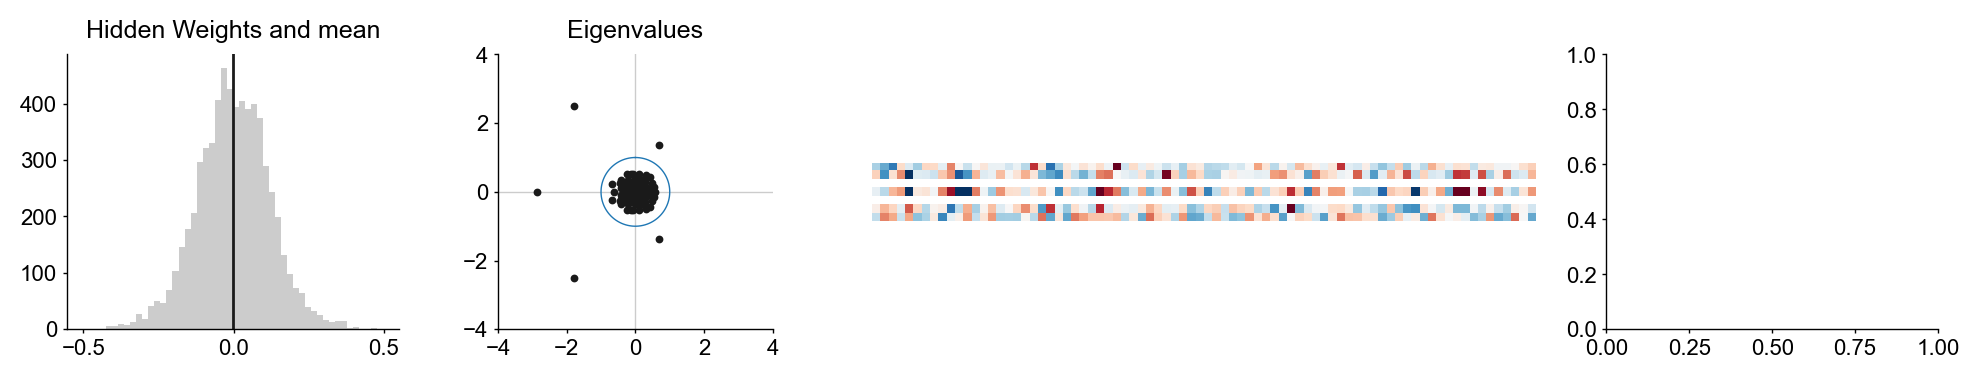

In [313]:
fig, ax = plt.subplots(1, 4, figsize=(10, 2), width_ratios = [1, 1, 2, 1])
w = rnn.h2h.weight.detach().numpy()
ax[0].hist(w.flatten(), bins=50, color=colors.subtle)
ax[0].axvline(w.mean(), color=colors.neutral)
ax[0].set_title('Hidden Weights and mean')
l, v = np.linalg.eig(w)
ax[1].scatter(l.real, l.imag, color=colors.neutral, s = 4)
ax[1].plot(np.sin(np.linspace(0, 2 * np.pi, 100)), np.cos(np.linspace(0, 2 * np.pi, 100)), color=colors.C[0], lw = 0.5)
vu.max_bounds(ax[1])
ax[1].set_title('Eigenvalues')
ax[1].axhline(0, color=colors.subtle, zorder = -3, lw = 0.5)
ax[1].axvline(0, color=colors.subtle, zorder = -3, lw = 0.5)
ax[1].set_aspect('equal')
vu.round_limits(ax[1], 0.6)
vu.nticks(ax[1], 5)
vrng = max(abs(v[:, 4].min()), abs(v[:, 4].max()))
_ = ax[2].imshow(np.stack([
    v[:, 0].real, v[:, 0].imag, v[:, 0].real * np.nan,
    v[:, 2].real, v[:, 2].real * np.nan,
    v[:, 3].real, v[:, 3].imag
]), cmap='RdBu', vmin=-vrng, vmax=vrng)
vu.axes_off(ax[2])
plotter.finalize(fig, None, despine = False)

In [314]:
th.manual_seed(0)
irnn = BasicRNN(x.shape[-1], 80, alpha = 0.8, act = nn.Sigmoid(), w_scale = 1, h_bias = 0, act_ofs = 0)

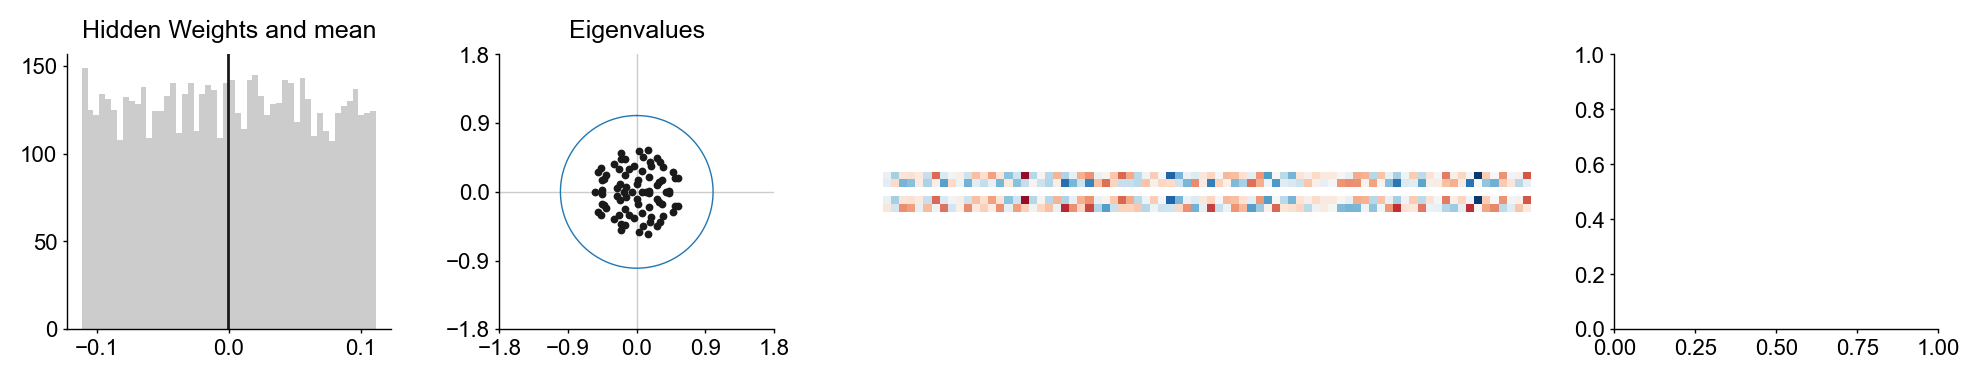

In [315]:
fig, ax = plt.subplots(1, 4, figsize=(10, 2), width_ratios = [1, 1, 2, 1])
w = irnn.h2h.weight.detach().numpy()
ax[0].hist(w.flatten(), bins=50, color=colors.subtle)
ax[0].axvline(w.mean(), color=colors.neutral)
ax[0].set_title('Hidden Weights and mean')
l, v = np.linalg.eig(w)
ax[1].scatter(l.real, l.imag, color=colors.neutral, s = 4)
ax[1].plot(np.sin(np.linspace(0, 2 * np.pi, 100)), np.cos(np.linspace(0, 2 * np.pi, 100)), color=colors.C[0], lw = 0.5)
vu.max_bounds(ax[1])
ax[1].set_title('Eigenvalues')
ax[1].axhline(0, color=colors.subtle, zorder = -3, lw = 0.5)
ax[1].axvline(0, color=colors.subtle, zorder = -3, lw = 0.5)
ax[1].set_aspect('equal')
vu.round_limits(ax[1], 0.6)
vu.nticks(ax[1], 5)
vrng = max(abs(v[:, 4].min()), abs(v[:, 4].max()))
_ = ax[2].imshow(np.stack([
    v[:, 0].real, v[:, 0].imag, v[:, 0].real * np.nan, v[:, 1].real, v[:, 1].imag
]), cmap='RdBu', vmin=-vrng, vmax=vrng)
vu.axes_off(ax[2])
plotter.finalize(fig, None, despine = False)

##### why different effect of $w_{scale}$ on sigmoid and tanh?
- in tanh it changes the length / chaos of stimulus response
- in sigmoid it changes the base activity level

The only thing that appears to matter is whether $act(0) = 0$ or not. Softplus
and ReLu + 0.5 are good examples. Whether activations can be negative appears
irrelevant.

In [ ]:
def vectorfield(dt_step, ax, xs, ys, scale = 0.1, normalize = False, **arrow_kws):
    xx, yy = np.meshgrid(xs, ys)
    shape = xx.shape
    s = np.stack([xx.ravel(), yy.ravel()], axis=1)
    s = np.array(s)
    ds = dt_step(s)
    if normalize:
        ds /= np.linalg.norm(ds, axis=1)[:, None]
    ds *= scale
    ax.quiver(xx, yy, ds[:, 0].reshape(shape), ds[:, 1].reshape(shape), **arrow_kws)
    ax.set_aspect('equal')

In [ ]:
# h_new = (1 - self.alpha) * h + self.alpha * fh
# fh = w_scale * W tan(h) + V x
# or
# fh = w_scale * W sigmoid(h) + V x

# When does h_new = h? when h = fh, aka when
#    V x = h - W rho(h)
# in absence of input, when
#    h = W rho(h)
# if rho(0) = 0 then this has a solution at 0, but otherwise the solution if it
# exists will be some black magic (copilot suggested this phrasing and I like it
# so it stays)
# when the stable point is not at 0, it becomes difficult to linearly read out
# the deviations from this fixed point

tensor(0.6931)

#### at the very least, this works with a ReLU

Success in with freely signed recurrent weights and ReLU activation

In [253]:
th.manual_seed(0)
rnn = BasicRNN(x.shape[-1], 80, alpha = 0.8, act = nn.ReLU(), w_scale=1)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:25<00:00, 39.06it/s]


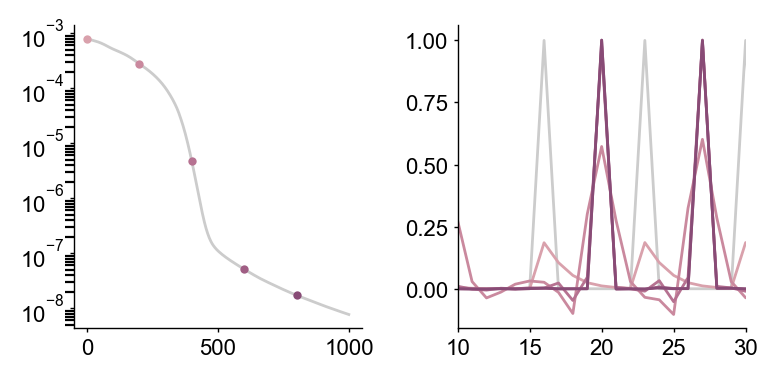

In [254]:
fig, ax = plot_rnn_training(losses, yhats, x)
ax[1].set_xlim(10, 30)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

Failure with negative-constrained weights and ReLU activation 

In [258]:
th.manual_seed(0)
rnn = NegRNN(x.shape[-1], 80, alpha = 0.8, act = nn.ReLU(), w_scale=1)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-5)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:31<00:00, 31.36it/s]


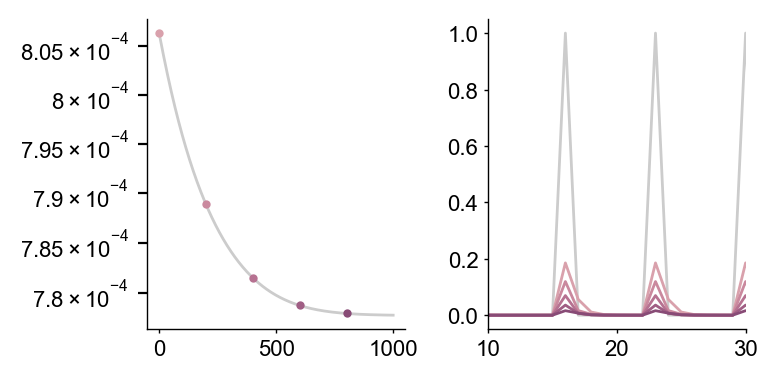

In [262]:
fig, ax = plot_rnn_training(losses, yhats, x)
ax[1].set_xlim(10, 30)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

### sign-locked weights plus small excitatory subunit

Adding a low-rank positive matrix to the negative recurrent matrix allows the
network to do the task.

In [315]:
class PosLRRNN(RNNd):
    def __init__(self, nx = 4, nh = 10, ne = 2, ny=None, alpha = 0.1, act = nn.Sigmoid(), h_bias = 0, w_scale = 1, act_ofs = 0):
        """
        Approximate dynamical RNN with negative weights and a small excitatory subnit.
        """
        nn.Module.__init__(self)
        init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)
        self.ne = ne
    
        self.i2h = nn.Linear(self.nx, self.nh, bias = False)
        self.h2h = SignedLinear(self.nh, sign = -1, allow_diag=False)
        self.h2e = SignedLinear(self.nh, self.ne, sign = 1)
        self.e2h = SignedLinear(self.ne, self.nh, sign = 1)
        self.h2y = nn.Linear(self.nh, self.ny, bias = False)


    def forward(self, x, h):
        h_act = self.act(h)
        e = self.h2e(h_act)
        fh = self.h2h(h_act) + self.i2h(x) + self.e2h(e)
        h_new = (1 - self.alpha) * h + self.alpha * fh
        y = self.h2y(h_new)
        return y, h_new

In [327]:
th.manual_seed(0)
rnn = PosLRRNN(x.shape[-1], 60, 20, alpha = 0.8, act = nn.ReLU(), w_scale=1)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:42<00:00, 23.50it/s]


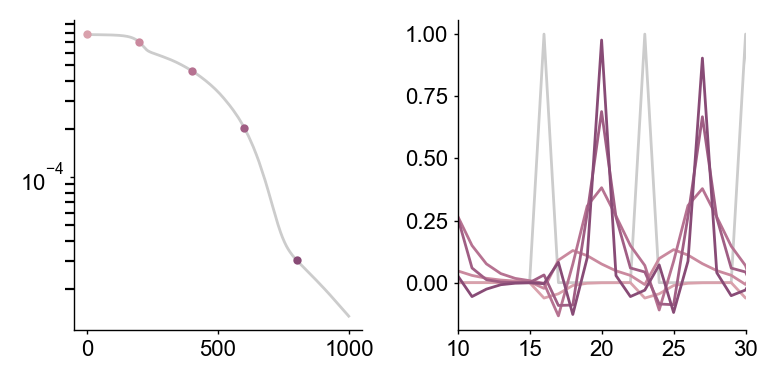

In [328]:
fig, ax = plot_rnn_training(losses, yhats, x)
ax[1].set_xlim(10, 30)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

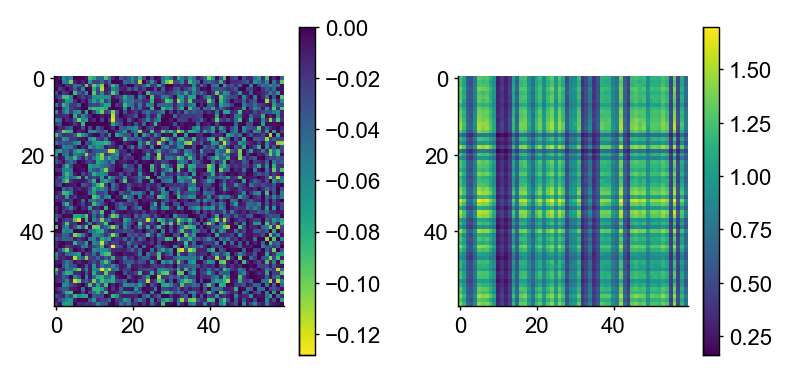

In [329]:
fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharex = True)
_ = ax[0].imshow(rnn.h2h._weight().detach().numpy(), cmap = 'viridis_r')
plt.colorbar(_)
_ = ax[1].imshow(rnn.e2h.weight.detach().numpy() @ rnn.h2e.weight.detach().numpy())
plt.colorbar(_)
plotter.finalize(fig, None)

### Context-dependent task and sensory switching

In [148]:
x, y = SimpleTasks.cdfi(
    interval = 4, iti_halflife = 3, iti_min = 3, session_length = 180, n_sessions = 5, n_dim = 2
)
ndim = x.shape[-1] // 2
m = th.tensor(x[..., ndim:], dtype=th.float32)
x = th.tensor(x[..., :ndim], dtype=th.float32)
y = th.tensor(y, dtype=th.float32)


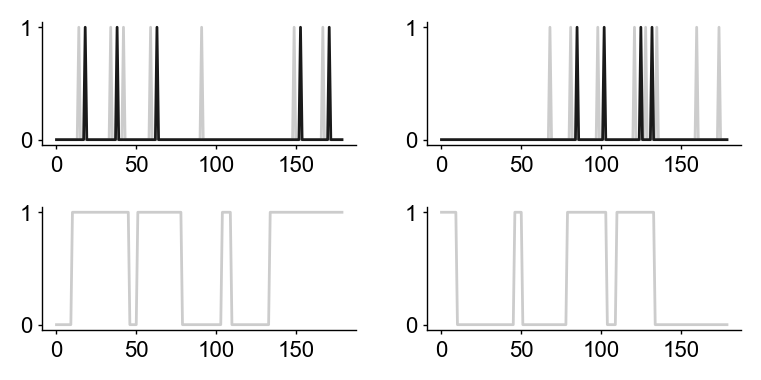

In [150]:
fig, ax = plt.subplots(2, ndim, figsize=(ndim * 2, 2))
session = 4
for i in range(ndim):
    ax[0, i].plot(x.numpy()[session, :, i], color = colors.subtle)
    ax[1, i].plot(m.numpy()[session, :, i], color = colors.subtle)
    ax[0, i].plot(y.numpy()[session, :, i], color = colors.neutral)
plotter.finalize(fig, None)

In [151]:
th.manual_seed(0)
rnn = BasicRNN(ndim * 2, 80, ndim, alpha = 0.8, act = nn.ReLU(), w_scale=1)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-4)
losses, yhats, hs = fit_rnn(rnn, th.concat([x, m], axis = -1), y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:19<00:00, 52.35it/s]


In [155]:
def plot_mrnn_training(losses, yhats, x, m, start = 0, pal = colors.ch0, n_iter = 5, session = 0, col_buffer = 3):
    ndim = x.shape[-1]
    skip = len(losses) // n_iter

    fig, ax = plt.subplots(2, ndim + 1, figsize=(ndim * 2 + 2, 2), height_ratios = [2, 1])
    ax[0, 0].plot(losses, color = colors.subtle)

    buf = col_buffer * skip
    pal = colors.ch0(np.arange(start - buf, len(losses) + buf, skip))
    for i in range(ndim):
        ax[0, i+1].plot(x.numpy()[session, :, i], color=colors.subtle)
        ax[1, i+1].plot(m.numpy()[session, :, i], color = colors.subtle)
        ax[0, i+1].sharex(ax[0, 1])
        ax[1, i+1].sharex(ax[0, 1])
        for j in range(start, len(losses), skip):
            ax[0, 0].plot([j], [losses[j]], 'o', ms = 3, color = pal[j])
            ax[0, i+1].plot(yhats[j, session, :, i], color=pal[j])
    ax[0, 0].set_yscale('log')
    ax[1, 0].set_axis_off()
    return fig, ax

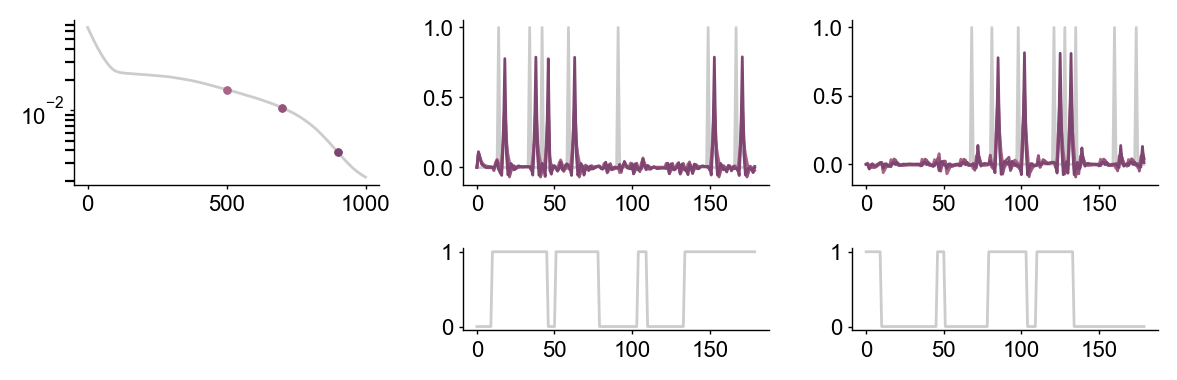

In [156]:
fig, ax = plot_mrnn_training(losses, yhats, x, m, start = 500, session = 4)
plotter.finalize(fig, None)

In [232]:
class BinaryLinear(SignedLinear):

    def __init__(self, n, n_out = None, sign = 1, sharpness = 0, scale = 1, allow_diag = True):
        super().__init__(n, n_out, sign, scale, allow_diag)
        self.sharpness = 2 ** sharpness

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
    
    def _weight(self):
        w = nn.functional.softmax(self.weight * self.sharpness, dim = 1)
        return (self.sign * self.scale) * w * self.mask

class MotifSenseRNN(RNNd):
    def __init__(self, nx = 4, nh = 10, ne = 2, nm = 2, ny=None, alpha = 0.1, act = nn.Sigmoid(), h_bias = 0, w_scale = 1, act_ofs = 0):
        """
        Approximate dynamical RNN with negative weights and a small excitatory
        subnit.
        
        e = h2e(act(h)) * m2e(m)
        fh = h2h(act(h)) + i2h(x) + e2h(e)
        h_new = (1 - alpha) * h + alpha * fh
        y = h2y(act(h_new))
        """
        nn.Module.__init__(self)
        init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)
        self.ne = ne
        self.nm = nm
    
        self.i2h = nn.Linear(self.nx, self.nh, bias = False)
        self.m2e = BinaryLinear(self.nm, self.ne, sharpness=3)
        self.h2h = SignedLinear(self.nh, sign = -1, allow_diag=False)
        self.h2e = SignedLinear(self.nh, self.ne, sign = 1)
        self.e2h = SignedLinear(self.ne, self.nh, sign = 1)
        self.h2y = nn.Linear(self.nh, self.ny, bias = False)


    def forward(self, x, m, h):
        h_act = self.act(h)
        e = self.m2e(m) * self.h2e(h_act)
        fh = self.h2h(h_act) + self.i2h(x) + self.e2h(e)
        h_new = (1 - self.alpha) * h + self.alpha * fh
        y = self.h2y(self.act(h_new))
        return y, h_new
    
    def seq_forward(self, x, m, h, states = False):
        y = th.zeros(x.shape[:-1] + (self.ny,))
        if states:
            hs = []
        for i in range(x.shape[1]):
            y_, h = self.forward(x[:, i], m[:, i], h)
            y[:, i] = y_
            if states:
                hs.append(h)
        if states:
            return y, th.stack(hs, dim=1)
        return y

In [218]:
def fit_mrnn(rnn, x, m, y, opt, loss_fn = nn.MSELoss(), n_steps = 2000, states = False):
    """
    Fit an RNN to batched sequences.

    Parameters
    ----------
    rnn : nn.Module
        The RNN model. Should have a function `seq_forward` that takes an input
        tensor and an initial hidden state tensor. And a function `init_hidden`
        that returns an initial hidden state tensor given a batch size.
    x : th.Tensor
        The input tensor. Should have shape (n_batch, n_step, n_inputs).
    y : th.Tensor
        The target tensor. Should have shape (n_batch, n_step, n_outputs).
    opt : optim.Optimizer
        The optimizer to use.
    loss_fn : nn.Module
        The loss function to use.
    n_steps : int
        The number of optimization steps to take.
    """

    losses = []
    yhats = []
    if states:
        h_hist = []

    for i in tqdm.trange(n_steps):
        opt.zero_grad()
        h_init = rnn.init_hidden(x.shape[0])
        _ = rnn.seq_forward(x, m, h_init, states)
        if states:
            yhat, hs = _
        else:
            yhat = _
        loss = loss_fn(yhat, y)
        loss.backward()
        opt.step()
        losses.append(loss.detach().numpy())
        yhats.append(yhat.detach().numpy())
        if states:
            h_hist.append(hs.detach().numpy())

    if states:
        return np.stack(losses), np.stack(yhats), h_hist
    return np.stack(losses), np.stack(yhats)

In [233]:
th.manual_seed(0)
rnn = MotifSenseRNN(ndim, 60, 10, ndim, ndim, alpha = 0.8, act = nn.ReLU())
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-3)
losses, yhats, hs = fit_mrnn(rnn, x, m, y, opt, n_steps = 1000, states = True)

100%|██████████| 1000/1000 [01:02<00:00, 16.04it/s]


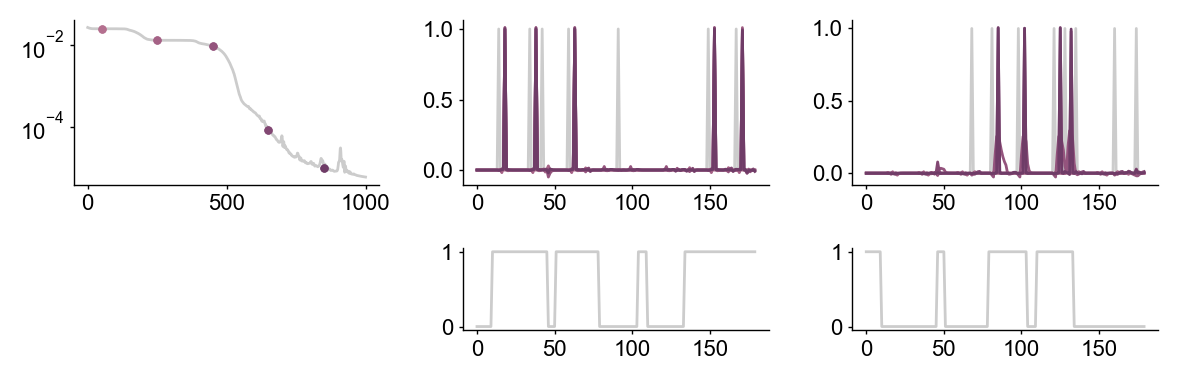

In [234]:
fig, ax = plot_mrnn_training(losses, yhats, x, m, start = 50, session = 4)
plotter.finalize(fig, None)

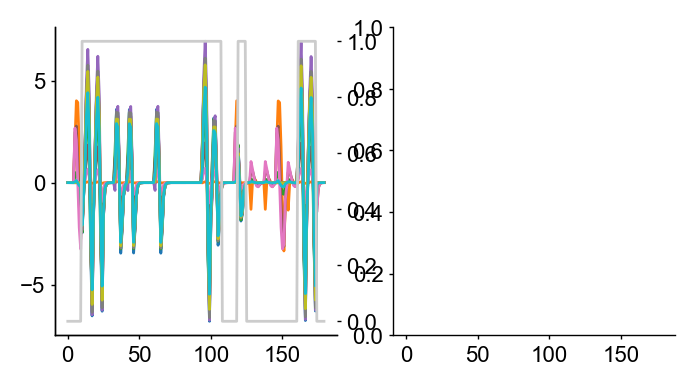

In [235]:
fix, ax = plt.subplots(1, 2, figsize=(4, 2), sharex = True)
session = 0
ax[0].plot(rnn.m2e(m).detach()[0] * rnn.h2e(th.tensor(hs[-1][session])).detach())
ax[0].twinx().plot(m.numpy()[session, :, 0], color = colors.subtle)
plotter.finalize(fig, None)

Reloading 'dynrn.rnntasks'.


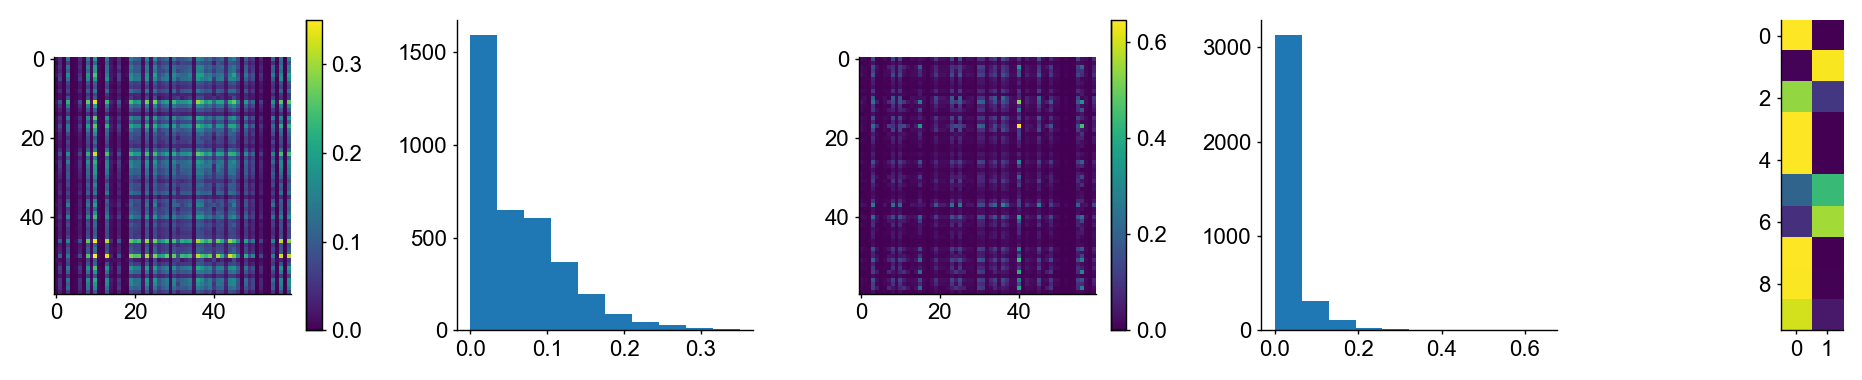

In [237]:
fig, ax = plt.subplots(1, 5, figsize=(10, 2))
m0_mat = rnn.e2h._weight() @ th.diag(rnn.m2e(th.tensor([1., 0]))) @ rnn.h2e._weight()
_ = ax[0].imshow(m0_mat.detach().numpy(), cmap = 'viridis', vmin = 0)
plt.colorbar(_)
ax[1].hist(m0_mat.detach().numpy().ravel())
m1_mat = rnn.e2h._weight() @ th.diag(rnn.m2e(th.tensor([0., 1]))) @ rnn.h2e._weight()
_ = ax[2].imshow(m1_mat.detach().numpy(), cmap = 'viridis', vmin = 0)
plt.colorbar(_)
ax[3].hist(m1_mat.detach().numpy().ravel())
_ = ax[4].imshow(rnn.m2e._weight().detach(), cmap = 'viridis', vmin = 0)
plotter.finalize(fig, None)

### Context information maintenance

In [414]:
x, y = SimpleTasks.ohflip(2, 4, 3, session_length = 50)
ndim = x.shape[-1]
x = th.tensor(x, dtype=th.float32)
y = th.tensor(y, dtype=th.float32)

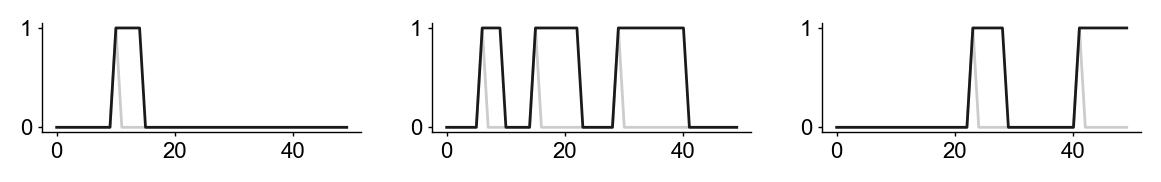

In [415]:
fig, ax = plt.subplots(1, ndim, figsize=(ndim * 2, 1))
session = 0
for i in range(ndim):
    ax[i].plot(x.numpy()[session, :, i], color = colors.subtle)
    ax[i].plot(y.numpy()[session, :, i], color = colors.neutral)
plotter.finalize(fig, None)

success with vanilla RNN

In [349]:
th.manual_seed(0)
rnn = BasicRNN(ndim, 80, ndim, alpha = 0.8, act = nn.ReLU(), w_scale=1)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-3)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 1000)

100%|██████████| 1000/1000 [00:03<00:00, 332.31it/s]


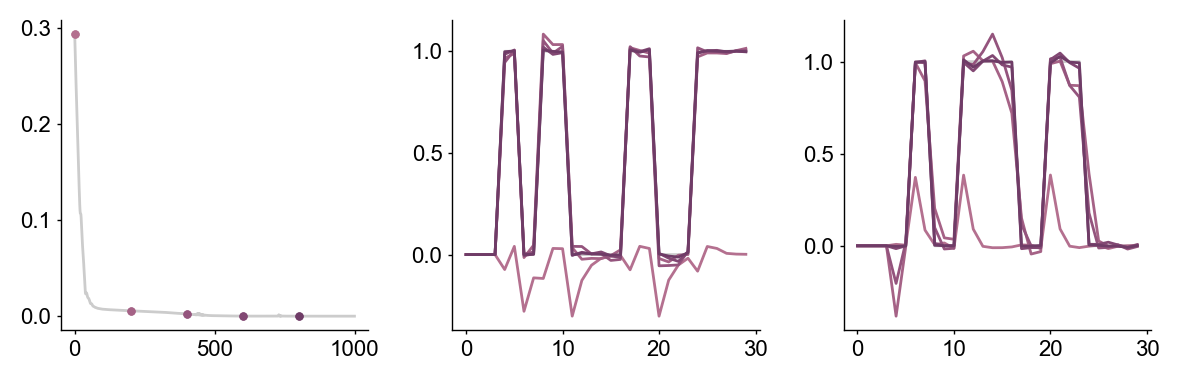

In [350]:
fig, ax = plot_rnn_training(losses, yhats, y)
plotter.finalize(fig, None)

Failure with negative weights

In [419]:
th.manual_seed(0)
rnn = NegRNN(x.shape[-1], 80, alpha = 0.8, act = nn.ReLU(), w_scale=1)
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-3)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 20000)

100%|██████████| 20000/20000 [02:01<00:00, 164.67it/s]


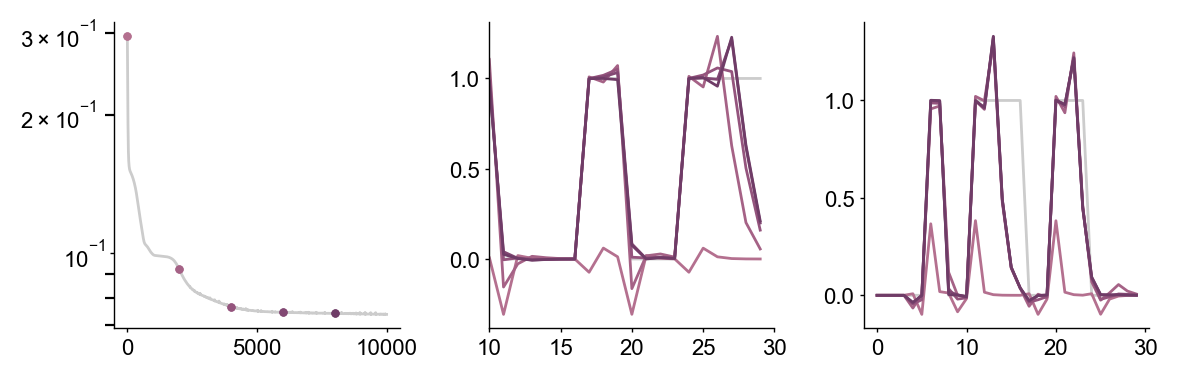

In [346]:
fig, ax = plot_rnn_training(losses, yhats, y)
ax[1].set_xlim(10, 30)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

Low-dimensional modulatory signal

In [408]:
class SwitchMotifRNN(RNNd):
    def __init__(self, nx = 4, nh = 10, nv = 10, ny=None, alpha = 0.1, act = nn.Sigmoid(), h_bias = 0, w_scale = 1, act_ofs = 0):
        """
        Approximate dynamical RNN with negative weights and a small excitatory subnit.
        """
        nn.Module.__init__(self)
        init_dynamical_rnn(self, nx, nh, ny, alpha, act, h_bias, w_scale, act_ofs)
        self.nv = nv
    
        self.vnn = NegRNN(self.nx, self.nv, 1, alpha = self.alpha, act = self.act)
        self.i2h = nn.Linear(self.nx, self.nh, bias = False)
        self.h2h = SignedLinear(self.nh, sign = -1, allow_diag=False)
        self.h2y = nn.Linear(self.nh, self.ny, bias = False)
        self.drive = nn.Parameter(th.zeros(1))

    def forward(self, x, h):
        # split h by block structure [h, h_vnn] and compute d output by vnn
        h, h_vnn = h[..., :self.nh], h[..., self.nh:]
        d, h_vnn = self.vnn(x, h_vnn)
        
        # compute main rnn dynamics
        h_act = self.act(h)
        fh = nn.functional.softplus(d - 2) * self.h2h(h_act) + self.i2h(x) + nn.functional.softplus(self.drive)
        h_new = (1 - self.alpha) * h + self.alpha * fh
        y = self.h2y(h_new)

        h = th.cat([h_new, h_vnn], dim = -1)
        return y, h
    
    def init_hidden(self, batch_size):
        return th.cat([th.zeros(batch_size, self.nh + self.nv)], dim = -1)

In [416]:
th.manual_seed(1)
rnn = SwitchMotifRNN(x.shape[-1], 130, nv = 120, alpha = 0.8, act = nn.ReLU())
opt = optim.Adam(rnn.parameters(), weight_decay=0, lr=1e-3)
losses, yhats, hs = fit_rnn(rnn, x, y, opt, n_steps = 2000)

100%|██████████| 2000/2000 [00:31<00:00, 62.68it/s]


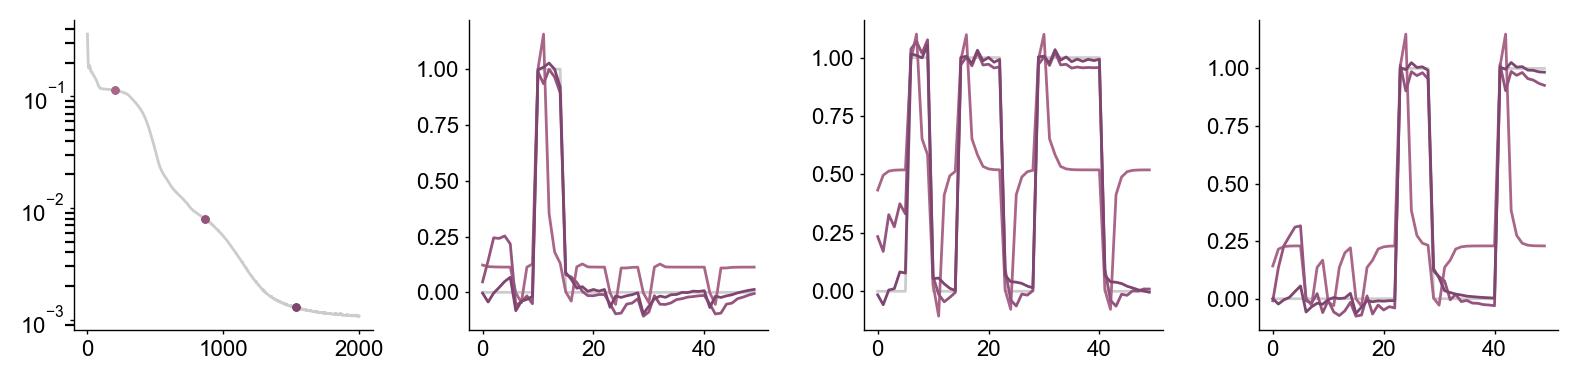

In [417]:
fig, ax = plot_rnn_training(losses, yhats, y, n_iter = 3, start = 200)
# ax[1].set_xlim(10, 30)
ax[0].set_yscale('log')
plotter.finalize(fig, None)

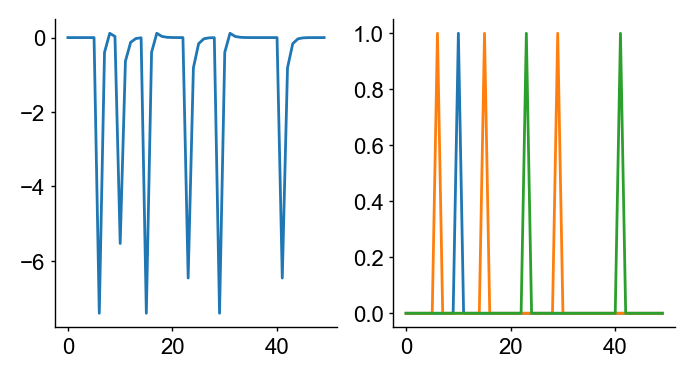

In [418]:
d, h_vnn = rnn.vnn.seq_forward(x, rnn.vnn.init_hidden(x.shape[0]))
session = 0
fig, ax = plt.subplots(1, 2, figsize=(4, 2), sharex = True)
ax[0].plot(d[session].detach())
ax[1].plot(x[session].detach())

In [377]:
d.shape

torch.Size([2, 30, 1])